In [1]:
# This example simulates TXI beamline for a Gaussian source and illustrates following cases:
# 1. Ideal mirrors
# 2. Including mirror imperfection
# 3. Modeling KB mirrors as thin lenses ( fast simulation)
# 4. Modeling KB as an extended objects ( time consuming)
# 5. Effect of KB misalignment on focusing when treating KBs as extended objects 

# This script is created by Jacek Krzywinski and modified by Juncheng E to read files in DEMO paths.

## Import modules

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

#Importing necessary modules:
import os
import sys
wpg_path = '/gpfs/exfel/data/user/juncheng/WPG/'
sys.path.insert(0,wpg_path)

import time
import copy
import numpy as np
import pylab as plt

import wpg

#import SRW core functions
from wpg.srwlib import srwl,SRWLOptD,SRWLOptA,SRWLOptC,SRWLOptT,SRWLOptL,SRWLOptMirEl
from wpg.srw.srwlib import SRWLWfr

#Wavefront plots
from wpg.wpg_uti_wf import calculate_fwhm, averaged_intensity, look_at_q_space, plot_t_wf

#openPMD wavefront
from pmd_wavefront.interfaces.srw import srw_wfr_from_openpmd_wavefront
from h5py import File

In [3]:
wpg.__file__

'/gpfs/exfel/data/user/juncheng/WPG/wpg/__init__.py'

In [4]:
#import SRW helpers functions
from wpg.useful_code.srwutils import AuxTransmAddSurfHeightProfileScaled

#import some helpers functions
from wpg.useful_code.wfrutils import calculate_fwhm_x, plot_wfront, calculate_fwhm_y, print_beamline, get_mesh
from wpg.useful_code.wfrutils import propagate_wavefront

#Import base wavefront class
from wpg import Wavefront
from wpg.beamline import Beamline
from wpg.optical_elements import Empty, Use_PP
#Gaussian beam generator
from wpg.generators import build_gauss_wavefront_xy, build_gauss_wavefront

In [5]:
plt.ion()

## Auxilliary

In [6]:
#Plotting
def plot_1d(profile, title_fig, title_x, title_y):
    plt.plot(profile[0], profile[1])
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    plt.title(title_fig)
    plt.grid(True)


def plot_2d(amap, xmin, xmax, ymin, ymax, title_fig, title_x, title_y):
    plt.imshow(amap, extent=(ymin, ymax, xmin, xmax))
    plt.colorbar()
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    plt.title(title_fig)

In [7]:
def _resample(wf, axis, data, x0, x1):
    if axis.lower()=='x':
        y = data[int(data.shape[0]/2),:]
        x = np.linspace(wf.params.Mesh.xMin, wf.params.Mesh.xMax, y.shape[0])
    elif axis.lower()=='y':
        y = data[:,int(data.shape[1]/2)]
        x = np.linspace(wf.params.Mesh.yMin, wf.params.Mesh.yMax, y.shape[0])
    else:
        raise ValueError(
            'Wrong axis {}, should be "x" or "y"'.format(axis))

    if not x0 is None:
        xmin = x0
    else:
        xmin = x[0]

    if not x1 is None:
        xmax = x1
    else:
        xmax = x[-1]

    x1 = np.linspace(xmin,xmax,len(y))
    y1 = np.interp(x1, x,y)
    return x1, y1

def intensity_cut(wf, axis, polarization, x0=None, x1=None):

    if polarization.lower()  == 'v' or polarization.lower() == 'vertical':
        pol = 'vertical'
    elif polarization.lower() == 'h' or polarization.lower() == 'horizontal':
        pol = 'horizontal'
    elif polarization.lower() == 't' or polarization.lower() == 'total':
        pol = 'total'
    else:
        raise ValueError(
            'Wrong polarization {}, should be "v" or "vertical"'+
            ' or "h" or "horizontal" or "t" or "total"'.format(polarization))

    data = wf.get_intensity(slice_number=0, polarization=pol)
    return _resample(wf, axis, data, x0, x1)

def phase_cut(wf, axis, polarization, x0=None, x1=None):

    if polarization.lower()  == 'v' or polarization.lower() == 'vertical':
        pol = 'vertical'
    elif polarization.lower() == 'h' or polarization.lower() == 'horizontal':
        pol = 'horizontal'
    else:
        raise ValueError(
            'Wrong polarization {}, should be "v" or "vertical" or "h" or "horizontal"'.format(polarization))

    data = wf.get_phase(slice_number=0, polarization=pol)
    return _resample(wf, axis, data, x0, x1)

In [8]:
#calculate source size from photon energy and FWHM angular divergence
def calculate_source_fwhm(ekev, theta_fwhm):
    wl = 12.39e-10/ekev
    k = 2 * np.sqrt(2*np.log(2))
    theta_sigma = theta_fwhm /k
    sigma0 = wl /(2*np.pi*theta_sigma)
    return sigma0*k

In [9]:
#calculate angular divergence using formula from CDR2011
def calculate_theta_fwhm_cdr(ekev,qnC):
    theta_fwhm = (17.2 - 6.4 * np.sqrt(qnC))*1e-6/ekev**0.85
    return theta_fwhm

In [10]:
#define optical path difference (OPD) from mirror profile, i.e.
#fill the struct opTrErMirr
#input:
#    mdatafile: an ascii file with mirror profile data
#    ncol:      number of columns in the file
#    delim:     delimiter between numbers in an row, can be space (' '), tab '\t', etc
#    Orient:    mirror orientation, 'x' (horizontal) or 'y' (vertical)
#    theta:     incidence angle
#    scale:     scaling factor for the mirror profile
def defineOPD(opTrErMirr, mdatafile, ncol, delim, Orient, theta, scale):
    heightProfData = np.loadtxt(mdatafile).T
    AuxTransmAddSurfHeightProfileScaled(opTrErMirr, heightProfData, Orient, theta, scale)
    plt.figure()
    plot_1d(heightProfData,'profile from ' + mdatafile,'x (m)', 'h (m)') #@todo add the func def in on top of example

In [11]:
def defineEFM(orient,p,q,thetaEFM,theta0,lengthEFM):
    """
    A wrapper to a SRWL function SRWLOptMirEl() for defining a plane elliptical focusing mirror propagator

    :param Orient:    mirror orientation, 'x' (horizontal) or 'y' (vertical)
    :param p:  the distance to two ellipsis centers
    :param q:  the distance to two ellipsis centers
    :param thetaEFM:  the design incidence angle in the center of the mirror
    :param theta0:    the "real" incidence angle in the center of the mirror
    :param lengthEFM: mirror length, [m]
    :return: the struct opEFM
    """
    if orient == 'x':     #horizontal plane ellipsoidal mirror
        opEFM = SRWLOptMirEl(_p=p, _q=q, _ang_graz=thetaEFM, _r_sag=1.e+40, _size_tang=lengthEFM,
                            _nvx=np.cos(theta0), _nvy=0, _nvz=-np.sin(theta0), _tvx=-np.sin(theta0), _tvy=0,
                             _x=0, _y=0, _treat_in_out=1)
    elif orient == 'y': #vertical plane ellipsoidal mirror
        opEFM = SRWLOptMirEl(_p=p, _q=q, _ang_graz=thetaEFM, _r_sag=1.e+40, _size_tang=lengthEFM,
                            _nvx=0, _nvy=np.cos(theta0), _nvz=-np.sin(theta0), _tvx=0, _tvy=-np.sin(theta0),
                             _x=0, _y=0, _treat_in_out=1)
    else:
        raise TypeError('orient should be "x" or "y"')
    return opEFM

In [12]:
# For SimEx output

def calculate_fwhm(wfr):
    """
    Calculate FWHM of the beam calculating number of point bigger then max/2 throuhgt center of the image

    :param wfr:  wavefront
    :return: {'fwhm_x':fwhm_x, 'fwhm_y': fwhm_y} in [m]
    """
    intens = wfr.get_intensity(polarization='total').sum(axis=-1);


    mesh = wfr.params.Mesh
    dx = (mesh.xMax-mesh.xMin)/mesh.nx
    dy = (mesh.yMax-mesh.yMin)/mesh.ny

    x_center = intens[intens.shape[0]//2,:]
    fwhm_x = len(x_center[x_center>x_center.max()/2])*dx

    y_center = intens[:,intens.shape[1]//2]
    fwhm_y = len(y_center[y_center>y_center.max()/2])*dy
    return {'fwhm_x':fwhm_x, 'fwhm_y': fwhm_y}

def add_custom_data(wf, bl0):
    """ Utility to store additional info on the wavefront . """

    # Add more metadata.
    fwhm = calculate_fwhm(wf)


    wf.custom_fields['/misc/xFWHM'] = fwhm['fwhm_x']
    wf.custom_fields['/misc/yFWHM'] = fwhm['fwhm_y']
    wf.custom_fields['/params/beamline/printout'] = str(bl0)

    wf.custom_fields['/info/contact'] = [
        'Name: Liubov Samoylova', 'Email: liubov.samoylova@xfel.eu',
        'Name: Alexey Buzmakov', 'Email: buzmakov@gmail.com']
    wf.custom_fields['/info/data_description'] = 'This dataset contains infromation about wavefront propagated through beamline (WPG and SRW frameworks).'
    wf.custom_fields['/info/method_description'] = """WPG, WaveProperGator (http://github.com/samoylv/WPG)is an interactive simulation framework for coherent X-ray wavefront propagation.\nSRW, Synchrotron Radiation Workshop (http://github.com/ochubar/SRW),  is a physical optics computer code  for simulation of the radiation wavefront propagation through optical systems of beamlines as well as  detailed characteristics of Synchrotron Radiation (SR) generated by relativistic electrons in magnetic fields of arbitrary configuration."""
    wf.custom_fields['/info/package_version'] = '2014.1'

In [13]:
# basic parameters used for defining the beamline and calculating photon source
qnC = 0.1                    # e-bunch charge, [nC]
ekev = 4.0                   # photon energy

thetaOM = 7.e-3    # angle of incidence for the offset mirror
d2m1 = 90.66       # distance to the first offset mirror
d2hkb = 119.75     #distance to the first HFM KB
thetaKB = 7.e-3     # angle of incidence for the KB mirrorsr
dhkb_foc = 3.5     # nominal focal length for HFM KB
dvkb_foc = 2.5      # nominal focal length for VFM KB
dhkb_vkb = dhkb_foc - dvkb_foc       # distance between centers of HFM and VFM
lengthOM=0.8        #length of the offset mirror
lengthKB=0.8        # length of the KB mirror

z1 = d2m1

## Load wavefront_genesis.h5

In [22]:
# #**********************Input Wavefront Structure and Parameters
print('*****defining initial wavefront and writing electric field data to h5-file...')
strInputDataFolder = '../wpg-samples/data_common'  # input data sub-folder name
strOutputDataFolder = './'  # output data sub-folder name

#define unique filename for storing results
ip = np.floor(ekev)
frac = np.floor((ekev - ip)*1e3)
fname0 = 'g' + str(int(ip))+'_'+str(int(frac))+'kev'
print('save hdf5: '+fname0+'.h5')
ifname = os.path.join(strOutputDataFolder,fname0+'.h5')

with File('wavefront_genesis.h5', 'r') as h5:
    arEx, arEy, kwargs,  wrf_attrs = srw_wfr_from_openpmd_wavefront(h5['data']['000000']['meshes'],  iz_step=None)

srw_wf = SRWLWfr(arEx, arEy, **kwargs)
srw_wf.__dict__.update(wrf_attrs)   

#init WPG Wavefront helper class
mwf = Wavefront(srw_wf)

#store wavefront to HDF5 file
mwf.store_hdf5(ifname)

range_xy = mwf.get_limits()[1]*2

*****defining initial wavefront and writing electric field data to h5-file...
save hdf5: g4_0kev.h5
R-space


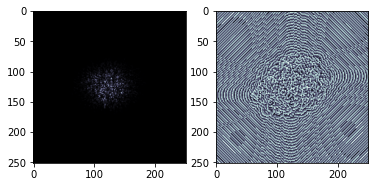

FWHMx [mm]: 0.02160000000000001
FWHMy [mm]: 0.019200000000000005
Coordinates of center, [mm]: -0.008399999999999987 -0.008399999999999987
stepX, stepY [um]: 1.2 1.2 

Total power (integrated over full range): 1.64513e-18 [GW]
Peak power calculated using FWHM:         1.18971e-18 [GW]
Max irradiance: 2.5214e-15 [GW/mm^2]
R-space
FWHMx [mm], theta_fwhm [urad]: 0.02160000000000001 0.2382528127068168


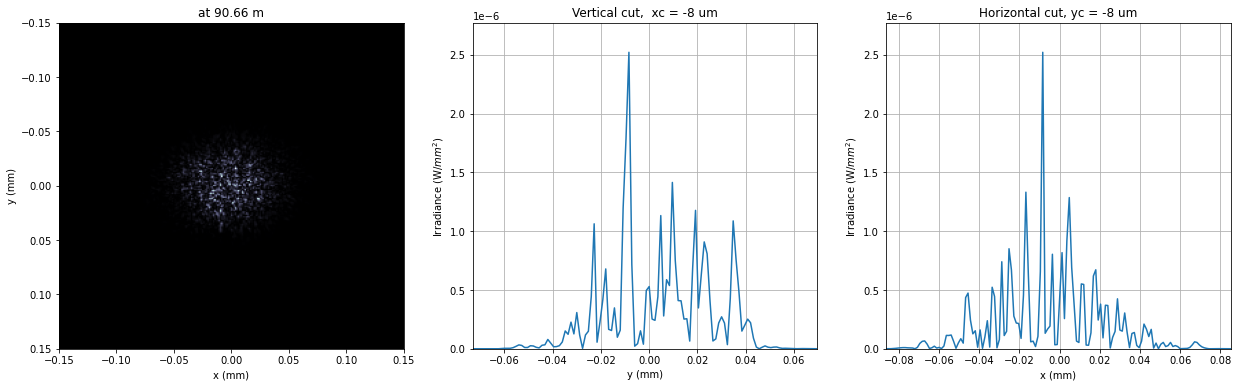

In [23]:
#draw wavefront with common functions
plt.subplot(1,2,1)
plt.imshow(mwf.get_intensity(slice_number=0))
plt.subplot(1,2,2)
plt.imshow(mwf.get_phase(slice_number=0,polarization='horizontal'))
plt.show()

#draw wavefront with cuts
plot_wfront(mwf, title_fig='at '+str(z1)+' m',
            isHlog=False, isVlog=False,
            i_x_min=1e-5, i_y_min=1e-5, orient='x', onePlot=True)

plt.set_cmap('bone') #set color map, 'bone', 'hot', 'jet', etc
fwhm_x = calculate_fwhm_x(mwf)
print('FWHMx [mm], theta_fwhm [urad]:',fwhm_x*1e3,fwhm_x/z1*1e6)

*****Defining optical beamline from first offset mirror (M1) to exp hall
*****HOM1 data for BL1 beamline 


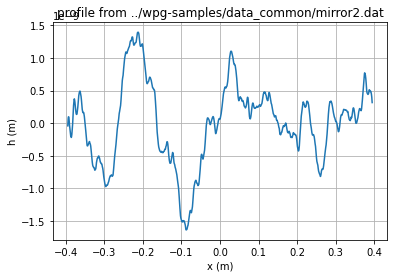

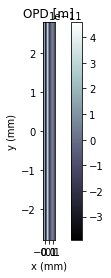

In [26]:
print('*****Defining optical beamline from first offset mirror (M1) to exp hall')

z2 = d2hkb - d2m1

DriftM1_KB = SRWLOptD(z2) #Drift from first offset mirror (M1) to exp hall
horApM1 = lengthOM*thetaOM
opApM1 = SRWLOptA('r', 'a', horApM1, range_xy)  # clear aperture of the Offset Mirror(s)
horApKB = lengthKB * thetaKB # Aperture of the KB system, CA 0.8 m

opApKB = SRWLOptA('r', 'a', horApKB, horApKB)  # clear aperture of the Offset Mirror(s)

#Wavefront Propagation Parameters:
#[0]:  Auto-Resize (1) or not (0) Before propagation
#[1]:  Auto-Resize (1) or not (0) After propagation
#[2]:  Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]:  Allow (1) or not (0) for semi-analytical treatment of quadratic phase terms at propagation
#[4]:  Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]:  Horizontal Range modification factor at Resizing (1. means no modification)
#[6]:  Horizontal Resolution modification factor at Resizing
#[7]:  Vertical Range modification factor at Resizing
#[8]:  Vertical Resolution modification factor at Resizing
#[9]:  Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#                 [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11]
ppM1 =            [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppTrErM1 =        [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftM1_KB =    [ 0,  0, 1.0,  1,  0, 2.4, 1.8, 2.4, 1.8,  0,  0,   0]
ppApKB =          [ 0,  0, 1.0,  0,  0, 0.6, 8.0, 0.6, 4.0,  0,  0,   0]
ppHKB =           [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppTrErHKB =       [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDrift_HKB_foc = [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDrift_KB =      [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppVKB =           [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppTrErVKB =       [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDrift_foc =     [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
#ppFin  =          [ 0,  0, 1.0,  0,  0, 0.05,5.0, 0.05,5.0,  0,  0,   0]
ppFin =           [ 0,  0, 1.0,  0,  1, .01, 20.0, .01, 20.0,  0,  0,   0]

# optBL0 = SRWLOptC([opApM1,  DriftM1_KB],
#                     [ppM1,ppDriftM1_KB])

optBL0 = SRWLOptC([opApM1  ],
                    [ppM1])

scale = 2     #5 mirror profile scaling factor
print('*****HOM1 data for BL1 beamline ')
opTrErM1 = SRWLOptT(1500, 100, horApM1, range_xy)
#defineOPD(opTrErM1, os.path.join(strInputDataFolder,'mirror1.dat'), 2, '\t', 'x',  thetaOM, scale)
defineOPD(opTrErM1, os.path.join(strInputDataFolder,'mirror2.dat'), 2, ' ', 'x',  thetaOM, scale)
opdTmp=np.array(opTrErM1.arTr)[1::2].reshape(opTrErM1.mesh.ny,opTrErM1.mesh.nx)
plt.figure()
plot_2d(opdTmp, opTrErM1.mesh.xStart*1e3,opTrErM1.mesh.xFin*1e3,opTrErM1.mesh.yStart*1e3,opTrErM1.mesh.yFin*1e3,
        'OPD [m]', 'x (mm)', 'y (mm)')

In [27]:
print('*****Collimating CRL and ideal mirror')
bPlotted = False
isHlog = False
isVlog = False
bSaved = True
optBL = optBL0
strBL = 'bl0'
pos_title = 'at exp hall wall'
print('*****setting-up optical elements, beamline:'+ strBL)

bl = Beamline(optBL)
print(bl)

if bSaved:
    out_file_name = os.path.join(strOutputDataFolder, fname0+'_'+strBL+'_3D.h5')
    print('save hdf5:'+ out_file_name)
else:
    out_file_name = None

startTime = time.time()

## From /gpfs/exfel/data/user/juncheng/WPG/wpg/wpg_uti_wf.py ##
mwf = Wavefront()
mwf.load_hdf5(ifname)
bl.propagate(mwf)
add_custom_data(mwf,bl)
mwf.store_hdf5(out_file_name)
##

# mwf = propagate_wavefront(ifname, bl,out_file_name)
print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))

*****Collimating CRL and ideal mirror
*****setting-up optical elements, beamline:bl0
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.005600000000000001
	Dy = 0.0003
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	

save hdf5:./g4_0kev_bl0_3D.h5
propagation lasted: 0.2 min


*****Ideal mirror: HOM as an aperture


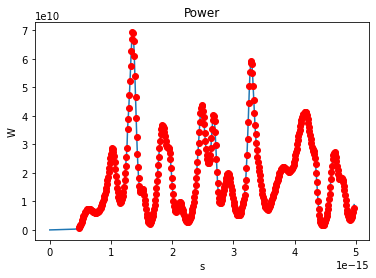

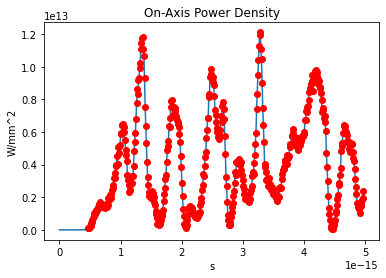

number of meaningful slices: 450
Pulse energy 8.5e-05 J
R-space
(251,) (251,)
FWHM in x = 5.976e-05 m.
FWHM in y = 6.215e-05 m.


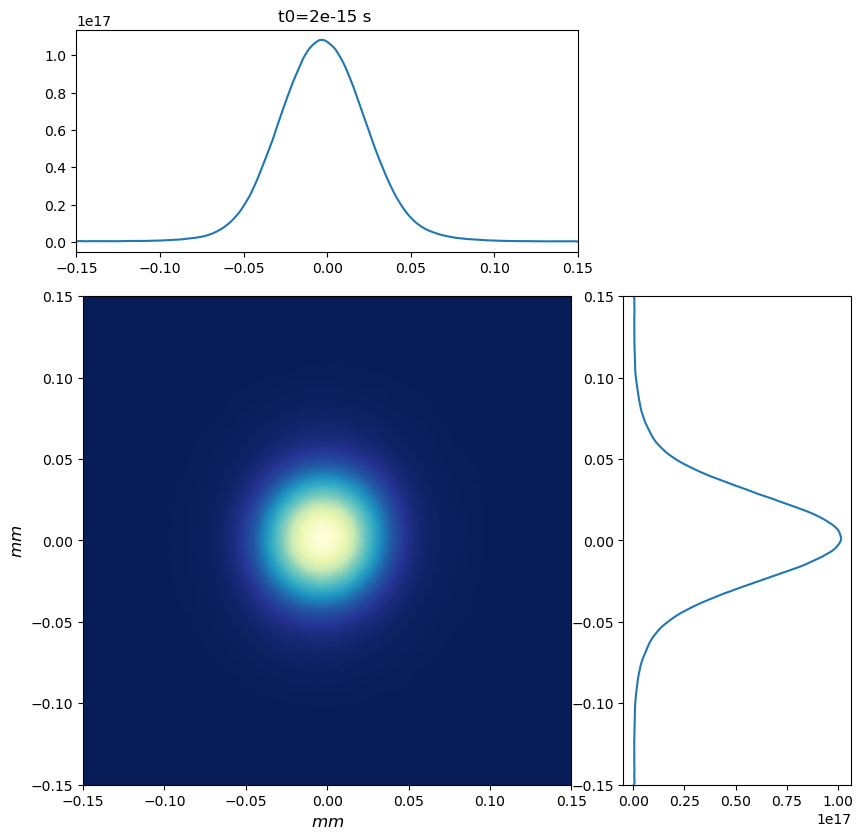

In [28]:
print('*****Ideal mirror: HOM as an aperture')
plot_t_wf(mwf)